# Tabular Learner with Fastai

The goal of this notebook is to implement a tabular deep learning model using fastai and submit to this week's competition. I eventually plan to build this out into a more structured and modular PyTorch project, but for now I want to make sure that this works and will generate reasonable results.

There's a lot to explore -- such as choice of loss function and evaluation metri [link](https://forum.numer.ai/t/model-evaluation-metrics/337) -- but we're keeping it simple for now.

## Dependencies and Data Download

In [1]:
# import dependencies
import os
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import numerapi
from fastai.tabular.all import *

# Secrets setup
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
public_key = os.environ.get("NUMERAI_PUBLIC_KEY")
private_key = os.environ.get("NUMERAI_PRIVATE_KEY")

napi = numerapi.NumerAPI(verbosity="info", public_id=public_key, secret_key=private_key)
napi.download_current_dataset(dest_path="../input/", unzip=True)

/home/djliden91/.virtualenvs/numerai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
2021-02-14 21:03:32,698 INFO numerapi.base_api: target file already exists


'../input/numerai_dataset_251.zip'

## Data Setup

In [2]:
filename = "../input/numerai_dataset_251/numerai_tournament_data.csv"
iter_csv = pd.read_csv(filename, iterator=True, chunksize=chunksize)
val_df = pd.concat([chunk[chunk['data_type'] == 'validation'] for chunk in iter_csv])
val_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [3]:
training_data = pd.read_csv("../input/numerai_dataset_250/numerai_training_data.csv")
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [4]:
training_data = pd.concat([training_data, val_df])
training_data.reset_index(drop=True, inplace=True)

In [5]:
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]
target_cols = ['target']

In [7]:
train_idx, test_idx = training_data.index[training_data.data_type=='train'].tolist(),training_data.index[training_data.data_type=='validation'].tolist()
splits = (list(train_idx), list(test_idx))
#train_idx, test_idx

In [16]:
categorical = ['era']
data = TabularPandas(training_data, cat_names=None,
                    cont_names=list(feature_cols.values),
                    y_names=target_cols, splits = splits)
len(data.train), len(data.valid)

(501808, 137779)

In [19]:
dls = data.dataloaders()

(tensor([], size=(64, 0), dtype=torch.int64),
 tensor([[0.7500, 0.7500, 0.7500,  ..., 0.0000, 0.5000, 1.0000],
         [0.5000, 0.7500, 0.7500,  ..., 0.5000, 1.0000, 0.2500],
         [0.5000, 0.5000, 0.7500,  ..., 0.7500, 0.2500, 0.0000],
         ...,
         [0.2500, 0.2500, 0.2500,  ..., 0.7500, 0.0000, 0.2500],
         [0.0000, 0.5000, 0.7500,  ..., 0.7500, 0.2500, 0.5000],
         [0.5000, 0.7500, 0.7500,  ..., 0.2500, 0.5000, 0.2500]]),
 tensor([[0.5000],
         [0.7500],
         [0.5000],
         [0.5000],
         [0.5000],
         [0.5000],
         [0.5000],
         [0.5000],
         [0.7500],
         [0.5000],
         [0.5000],
         [0.0000],
         [0.5000],
         [1.0000],
         [0.7500],
         [0.2500],
         [0.5000],
         [0.5000],
         [0.7500],
         [0.0000],
         [0.7500],
         [0.7500],
         [0.7500],
         [0.5000],
         [0.5000],
         [0.2500],
         [0.7500],
         [0.5000],
         [0.7500

In [42]:
learn = tabular_learner(dls, layers=[200,100],
                        loss_func=MSELossFlat(),
                        metrics = [PearsonCorrCoef()])
#learn.lr_find()

In [43]:
learn.fit_one_cycle(6, wd = 2)

epoch,train_loss,valid_loss,pearsonr,time
0,0.049720,0.050422,0.001910,02:11
1,0.049845,0.049998,0.009304,02:10
2,0.050639,0.049963,0.001669,02:11


KeyboardInterrupt: 

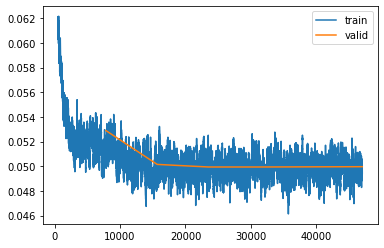

In [25]:
learn.recorder.plot_loss(skip_start = 500)

In [18]:
from scipy.stats import spearmanr
  
def sharpe(df: pd.DataFrame) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

# Would like to make this a metric that can be tracked with
# fastai but am not sure how.
prediction, target = learn.get_preds()
prediction = prediction.numpy().squeeze()
target = target.numpy().squeeze()
prediction, target

era = dls.valid_ds.items['era']
eval_df = pd.DataFrame({'prediction':prediction, 'target':target, 'era':era}).reset_index()
spearmanr(eval_df.target, eval_df.prediction)

sharpe(eval_df)

1.003071825604563

In [47]:
ids = []
preds = []

filename = "../input/numerai_dataset_251/numerai_tournament_data.csv"
chunksize = 100000
with pd.read_csv(filename, chunksize=chunksize) as reader:
    for chunk in reader:
        chunk.target = None
        test_dl = dls.test_dl(chunk[feature_cols])
        out,_ = learn.get_preds(dl=test_dl, inner=True)
        #test_df = chunk[feature_cols]
        #preds = learn.pred_batch(test_df)
        out = out.tolist()
        ids.extend(chunk["id"])
        preds.extend(out)

In [48]:
len(preds)

1649775

In [55]:
preds = [item for sublist in preds for item in sublist]

In [56]:
preds[0:10], ids[0:10], len(preds), len(ids)

([0.5053572654724121,
  0.4640941619873047,
  0.5228085517883301,
  0.49705970287323,
  0.5096885561943054,
  0.5069828033447266,
  0.5076218247413635,
  0.48761796951293945,
  0.4899097681045532,
  0.4771568179130554],
 ['n0003aa52cab36c2',
  'n000920ed083903f',
  'n0038e640522c4a6',
  'n004ac94a87dc54b',
  'n0052fe97ea0c05f',
  'n00a5ccf3b6b2870',
  'n00bf78d0bbbc1b6',
  'n00c6fd95ff0c83e',
  'n00cd56868258aec',
  'n00e7d6fb71ef69f'],
 1649775,
 1649775)

In [57]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = pd.DataFrame({
    'id':ids,
    'prediction_kazutsugi':preds
})
predictions_df.head()

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.505357
1,n000920ed083903f,0.464094
2,n0038e640522c4a6,0.522809
3,n004ac94a87dc54b,0.497060
4,n0052fe97ea0c05f,0.509689


In [58]:
predictions_df.to_csv("../output/predictions.csv", index=False)
# Upload predictions
submission_id = napi.upload_predictions("../output/predictions.csv",
                                        model_id=os.environ.get("NUMERAI_MODEL_ID"))

2021-02-14 16:57:31,881 INFO numerapi.base_api: uploading predictions...
